Building a Binary Classification Model with Tensorflow

In [1]:
#importing our libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.feature_column import feature_column
import matplotlib.pyplot as plt

In [2]:
# load our datasets
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")
#shuffle our training data
train_df = train_df.sample(frac=1)

In [3]:
# normalizing train data using z-score
#calculate the mean for each column
train_df_mean = train_df.mean()
#calculating std for each column
train_df_std = train_df.std()
#normalize our data
train_df_norm = (train_df - train_df_mean)/train_df_std
train_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
8127,0.564596,-0.680858,0.668204,-0.303523,-0.494451,-0.553707,-0.419280,1.071150,1.117390
5778,0.684286,-0.821219,0.509310,-0.401232,-0.245340,-0.229623,-0.299651,-0.528562,-0.250043
12806,-1.121050,1.111089,0.668204,0.036852,0.093925,-0.025765,0.100848,-0.512840,-0.948416
4916,0.729171,-0.811862,0.429862,-0.184254,-0.245340,0.046544,-0.151414,0.319587,-0.187103
2930,0.898733,-0.891400,-1.079639,-0.781058,-0.648662,-0.926577,-0.658539,0.251563,-0.507838


In [4]:
# normalizing test data using z-score
test_df_mean = test_df.mean()
test_df_std = test_df.std()
test_df_norm = (test_df - test_df_mean)/test_df_std
test_df_norm.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.233523,0.814497,-0.146975,0.596319,0.315284,0.130224,0.317681,1.510494,1.227494
1,0.646236,-0.645823,1.127377,-0.505466,-0.529167,-0.576200,-0.582646,-0.112305,-0.259427
2,0.891858,-0.871210,-0.146975,0.459002,-0.055216,0.078795,0.013924,1.070971,0.571551
3,0.616160,-0.852428,-0.067328,-1.174887,-1.238892,-1.313675,-1.310570,1.255656,1.097543
4,-0.040503,0.326159,-0.784152,-0.630257,-0.687953,-0.536415,-0.692108,-0.469003,-1.097477


Creating a Binary Label for our Dataset 

We will be setting a threshold of 265000 as high price for houses, that's 1.0 for our normalized dataset

In [5]:
threshold = 1
train_df_norm['median_house_value_is_high'] = np.where(train_df_norm.median_house_value > 1, 1, 0)
test_df_norm['median_house_value_is_high'] = np.where(test_df_norm.median_house_value > 1, 1, 0)
display(train_df_norm.head(2), test_df_norm.head(2))

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_high
8127,0.564596,-0.680858,0.668204,-0.303523,-0.494451,-0.553707,-0.419280,1.071150,1.117390,1
5778,0.684286,-0.821219,0.509310,-0.401232,-0.245340,-0.229623,-0.299651,-0.528562,-0.250043,0


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,median_house_value_is_high
0,-1.233523,0.814497,-0.146975,0.596319,0.315284,0.130224,0.317681,1.510494,1.227494,1
1,0.646236,-0.645823,1.127377,-0.505466,-0.529167,-0.576200,-0.582646,-0.112305,-0.259427,0


Represent Features that will be used in training our model in a tensorflow feature column

In [6]:
# create an empty list that will hold our feature columns
feature_columns = []
# create a numerical feature column to represent median income
median_income = tf.feature_column.numeric_column('median_income')
feature_columns.append(median_income)
# create a numerical feature column to represent total rooms
total_rooms = tf.feature_column.numeric_column('total_rooms')
feature_columns.append(total_rooms)

#convert thr feature_columns list into a layer for our model
feature_layer = keras.layers.DenseFeatures(feature_columns)

#printing our feature_layer output
feature_layer(dict(train_df_norm))

<tf.Tensor: shape=(17000, 2), dtype=float32, numpy=
array([[ 1.0711501 , -0.30352315],
       [-0.52856153, -0.40123194],
       [-0.51283956,  0.03685208],
       ...,
       [-0.6275052 , -0.39022252],
       [-0.30022594,  0.6772346 ],
       [-0.4211804 ,  0.0818073 ]], dtype=float32)>

In [7]:
#initiating our model
model = keras.models.Sequential()

# adding our layers
model.add(feature_layer)
model.add(keras.layers.Dense(units=1, input_shape = (1,)))

# adding our optimizer and loss function
lr = 0.001
classification_threshold = 0.35
opt = tf.keras.optimizers.RMSprop(lr=lr)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold)
          ]
#compile
model.compile(optimizer=opt, loss = loss, metrics=metrics)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
# define our features and label
train_label = np.array(train_df_norm.pop('median_house_value_is_high'))
train_features = {name: np.array(value) for name, value in train_df_norm.items()}

test_label = np.array(test_df_norm.pop('median_house_value_is_high'))
test_feature = {name: np.array(value) for name, value in test_df_norm.items()}

In [9]:
# train our model
batch_size = 100
epochs = 20
lr = 0.001
classification_threshold = 0.35

history = model.fit(x=train_features, y=train_label, batch_size=batch_size, epochs=epochs)

Epoch 1/20


170/170 [==============================] - 1s 2ms/step - loss: 2.4726 - accuracy: 0.7057
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 2.2065 - accuracy: 0.7298
Epoch 3/20
170/170 [==============================] - 1s 3ms/step - loss: 1.9644 - accuracy: 0.7537
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 1.7385 - accuracy: 0.7753
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 1.5448 - accuracy: 0.7967
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 1.4273 - accuracy: 0.8144
Epoch 7/20
170/170 [==============================] - 1s 5ms/step - loss: 1.3905 - accuracy: 0.8197
Epoch 8/20
170/170 [==============================] - 0s 3ms/step - loss: 1.3568 - accuracy: 0.8285
Epoch 9/20
170/170 [==============================] - 1s 5ms/step - loss: 1.3148 - accuracy: 0.8384
Epoch 10/20
170/170 [==============================] - 0s 2ms/step - loss: 1.2674 - accuracy: 0.8455
Epoch 11/2

In [10]:
#define a plot function
def plot_function(ep, hist, metrics_list):
  plt.figure()
  plt.xlabel('Epochs')
  plt.ylabel('Value')
  for m in metrics_list:
    plt.plot(ep[1:],hist[m][1:],label=m)
  plt.title('Metrics Curve')
  plt.legend()
  plt.show()

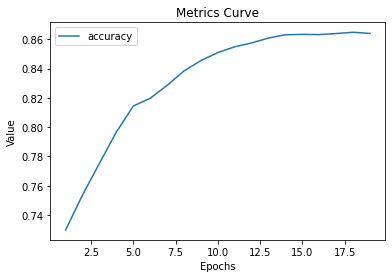

In [11]:
# plot our accuracy curve
ep = history.epoch 
hist = pd.DataFrame(history.history) #isolating the classification metric for each epoch
metrics_list = ['accuracy']

plot_function(ep, hist, metrics_list)

In [12]:
# evaluate the model using the test data
model.evaluate(x=test_feature, y=test_label, batch_size=batch_size)

30/30 [==============================] - 0s 2ms/step - loss: 1.1511 - accuracy: 0.8560


[1.1511492729187012, 0.8560000061988831]

Accuracy is not a good enough metric to evaluate our model, we will be adding precision and recall to our metrics in order to properly eveluate the model.

In [13]:
#initiating our model
new_model = keras.models.Sequential()

# adding our layers
new_model.add(feature_layer)
new_model.add(keras.layers.Dense(units=1, input_shape = (1,),activation=tf.sigmoid))

# adding our optimizer and loss function
lr = 0.001
classification_threshold = 0.52
opt = tf.keras.optimizers.RMSprop(lr=lr)
loss = tf.keras.losses.BinaryCrossentropy()
acc = tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                              threshold=classification_threshold)
pre = tf.keras.metrics.Precision(thresholds=classification_threshold,
                                 name='precision')
re = tf.keras.metrics.Recall(thresholds=classification_threshold,
                                 name='recall')
metrics = metrics=[acc, pre, re]
#compile
new_model.compile(optimizer=opt, loss = loss, metrics=metrics)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
# fit our new model with the training data
new_history = new_model.fit(x=train_features, y=train_label, batch_size=batch_size, epochs=epochs)

Epoch 1/20


170/170 [==============================] - 1s 2ms/step - loss: 0.6967 - accuracy: 0.7115 - precision: 0.3258 - recall: 0.7166
Epoch 2/20
170/170 [==============================] - 0s 2ms/step - loss: 0.6275 - accuracy: 0.7426 - precision: 0.3514 - recall: 0.6806
Epoch 3/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5650 - accuracy: 0.7702 - precision: 0.3794 - recall: 0.6392
Epoch 4/20
170/170 [==============================] - 0s 2ms/step - loss: 0.5090 - accuracy: 0.7954 - precision: 0.4125 - recall: 0.5952
Epoch 5/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4600 - accuracy: 0.8229 - precision: 0.4647 - recall: 0.5520
Epoch 6/20
170/170 [==============================] - 0s 2ms/step - loss: 0.4186 - accuracy: 0.8435 - precision: 0.5212 - recall: 0.5131
Epoch 7/20
170/170 [==============================] - 0s 2ms/step - loss: 0.3856 - accuracy: 0.8614 - precision: 0.5942 - recall: 0.4771
Epoch 8/20
170/170 [==============================] 

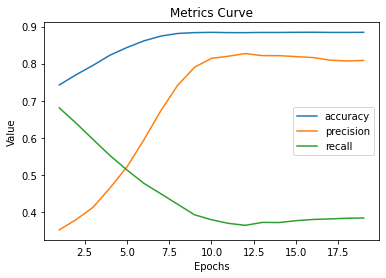

In [15]:
#plotting out metrics curves
new_ep = new_history.epoch
new_hist = pd.DataFrame(new_history.history)
new_metrics_list = ['accuracy', 'precision', 'recall']

plot_function(new_ep, new_hist, new_metrics_list)